# Setup 1: Single cell migration
Here, we aim to study **individual cell migration** by tracking **cell trajectories** and computing **mean and effective cell velocities**, as it has been done in [1](https://pubmed.ncbi.nlm.nih.gov/30143683/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from scipy import io as sio
import physipy as phypy

%matplotlib inline
sns.set_palette(['#0071BC', '#d95319', '#efb320'])

#  Reading output data
## Loading cell data
Our data consists of **3 different matrix density values**, which correspond to **collagen concentrations** of **2.5, 4.0 and 6.0 mg/mL**. For each of these conditions, we have **80 replicates**, and, for each replicate, we have **73 data points** (corresponding to 24 hours of simulation, captured at each 20 minutes).

The data we want to extract from the output files corresponds to the **cell coordinates** at each timestep. Thus, we will go through all densities, replicates and time points and store the cell coordinates for each condition.

In [2]:
number_of_replicates = 80
number_of_timepoints = 73
densities_values = [2.5, 4.0, 6.0]
densities_folders = ['LowDensity', 'MedDensity', 'HighDensity']
variables = ['position_x', 'position_y', 'position_z']
base_folder = Path('../data/MotilityStudy_Poly')

In [3]:
# Create empty list to store the information from all cells
cells_list = []

for density, density_value in zip(densities_folders, densities_values):
    for replicate in range(1, number_of_replicates + 1):
        for timestep in range(number_of_timepoints):
            # Extract data from output folder
            folder_name = base_folder / '{}/output{}/'.format(density, str(replicate))
            cells = phypy.get_cell_data(timestep, folder_name, variables)
            
            # Store info of the only cell (indexed 0) in the results
            cells_data = [cells[variable][0] for variable in variables]
            settings_data = [timestep, replicate, density, density_value]
            cells_list_temp = cells_data + settings_data
            
            cells_list.append(cells_list_temp)

This structure we just created is a list of lists comprising the cell coordinates, the time point at which the data was recorded, the replicate and the density of the collagen matrix.

In [4]:
print(cells_list[0])
print(cells_list[-1])

[0.0, 0.0, 0.0, 0, 1, 'LowDensity', 2.5]
[-1.6367871283016406, 11.69746026499171, -9.992433640903519, 72, 80, 'HighDensity', 6.0]


We have all the data we need. However, for data manipulation and visualization applications, Pandas DataFrames provide some advantages over these simpler structures. Thus, we can transform our list of lists into a DataFrame to ease this process.

In [5]:
# Turning cell list into DataFrame
cells_df = pd.DataFrame(cells_list, columns=['position_x', 'position_y', 'position_z', 
                                             'timestep', 'replicate',
                                             'density', 'col_concentration'])

# Print initial lines of the DataFrame
cells_df.head()

,position_x,position_y,position_z,timestep,replicate,density,col_concentration
0,0.000000,0.000000,0.000000,0,1,LowDensity,2.5
1,0.079267,0.189096,-1.681153,1,1,LowDensity,2.5
2,0.035418,0.160612,-2.346963,2,1,LowDensity,2.5
3,-0.271286,0.468947,-0.532827,3,1,LowDensity,2.5
4,-0.577990,0.777282,1.281309,4,1,LowDensity,2.5


# **Data processing**
## **Plotting cells trajectories**
Having defined the cells DataFrame, we can **study cell motility and how it is influenced by the matrix density**. To do so, we will keep track of the cell trajectories, by plotting the cells' x and y positions through time. We will only look into the xy plane to compare our results to those found in [1]((https://pubmed.ncbi.nlm.nih.gov/30143683/)).

We choose to represent the **trajectory of each cell as a line**, and the **cell's final position as a round marker**. 

Plotting the **final positions** of the cells can be easily achieved using our DataFrame through scatterplots drawn in a FacetGrid, in which each column corresponds to matrix density value. We only need to select the data points of interest, which correspond to the last recorded time point.

As for plotting the **cell trajectories**, we will need to select the data points for each cell/replicate at a time, to avoid mixing cell data. Thus, for column of the FacetGrid previously created, we will be access the cells that correspond to the corresponding matrix density, one at a time, and plot the x and y positions for all time points.

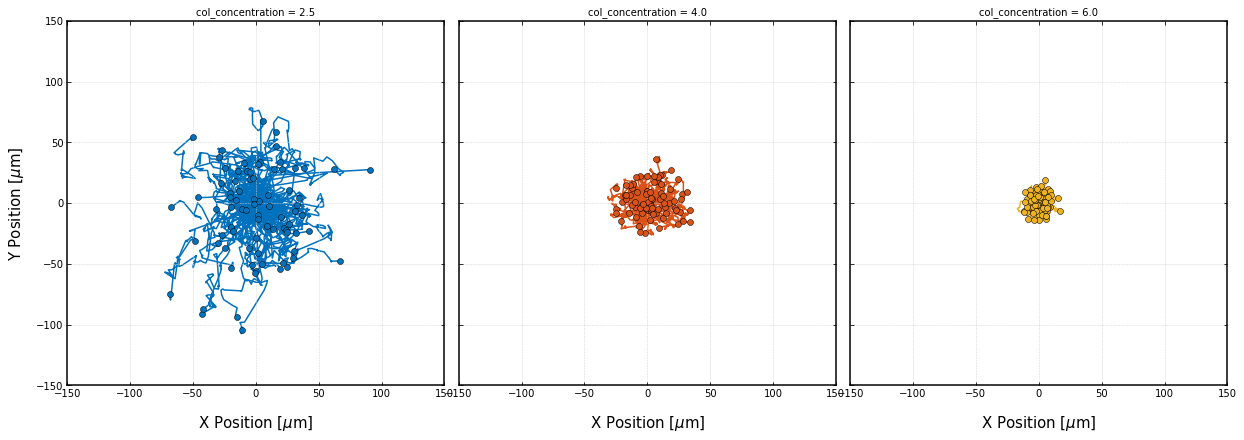

In [7]:
axes_xlims = (-150, 150)
axes_ylims = axes_xlims

# Build a FacetGrid with a scatter plot of the final position of the cells
last_time_point_data = cells_df[cells_df['timestep'] == 72]

g = sns.FacetGrid(last_time_point_data, col='col_concentration',
                  hue='density', height=6, aspect=0.95)

g = (g.map(plt.scatter, 'position_x', 'position_y', edgecolor='black', linewidth=0.5, zorder=2)
    .set(ylim=axes_xlims)
    .set(xlim=axes_xlims)
    .set_ylabels('Y Position [$\mu$m]', labelpad=10, fontsize=15)
    .set_xlabels('X Position [$\mu$m]', labelpad=15, fontsize=15))

# Plot cell trajectories inside the FacetGrid
for index, (ax, density) in enumerate(zip(g.axes.flatten(), densities_folders)):
    for replicate in range(1, number_of_replicates + 1):
        # Select data points of interest
        cell_query = 'replicate == {} & density == "{}"'.format(str(replicate), density)
        cell_indexes = cells_df.query(cell_query).index.to_list()
        
        # Plot trajectories
        ax.plot(cells_df['position_x'].iloc[cell_indexes], cells_df['position_y'].iloc[cell_indexes],
                c='C{}'.format(str(index)), zorder=-1)
        
        # Figure aesthetics
        phypy.set_cell_view_style_axes(ax, axes_lim=150)

## **Computing instantaneous cell velocities**
We also need to analyze the effect of **matrix density** on the distribution of cell velocities. Firstly, we will be calculating the instantaneous velocities for the cells (i.e., the mean velocity between each time point). 

We first need to compute the **traveled distance** between time points, which is equivalent to the **Euclidian distance** between two points. Once the distances between points have been obtained, we are able to **convert them to velocity values** by dividing them by the time interval passed between frames.

In [ ]:
# Define time interval between frames (min) to compute velocity
time_interval = 20

# Create traveled distance and velocity columns in the cells DataFrame
cells_df['distance'] = 0
cells_df['velocity'] = 0

for density in densities_folders:
    for replicate in range(1, number_of_replicates + 1):
        # Select data points of interes
        cell_query = 'replicate == {} & density == "{}"'.format(str(replicate), density)
        cell_indexes = cells_df.query(cell_query).index.to_list()
        
        # Get the differences in coordinates between time points
        x_diff = np.diff(cells_df.iloc[cell_indexes]['position_x'])
        y_diff = np.diff(cells_df.iloc[cell_indexes]['position_y'])
        z_diff = np.diff(cells_df.iloc[cell_indexes]['position_z'])
        
        # Compute traveled distance between time points
        sum_squared_diffs = x_diff**2 + y_diff**2 + z_diff**2
        distances = np.sqrt(sum_squared_diffs)
        # Compute cell velocity
        velocities = distances/time_interval
        
        # Leave initial distance and velocity as zero
        cell_indexes.pop(0)
        
        # Add info to the cells DataFrame
        cells_df.at[cell_indexes, 'distance'] = distances
        cells_df.at[cell_indexes, 'velocity'] = velocities

### Instantaneous velocities stats
With this information, for each of the matrix density values, we can compute some metrics, such as:
- Mean cell velocity;
- Median cell velocity;
- Standard error of the mean

These metrics have also been computed for the experimental results, so we can compare our results to that data. Furthermore, it provides us with a better understanding of the effect of the density of the collagen matrices.

In [ ]:
for density_value in densities_values: 
    cells = cells_df[cells_df['col_concentration'] ==  density_value]
    cells_velocities = cells['velocity']
    
    print('Density: {} [mg/mL]'.format(density_value))
    print('Count: {}'.format(cells_velocities.count()))
    print('Mean: {} [micron/min]'.format(round(cells_velocities.mean(), 4)))
    print('Median: {} [micron/min]'.format(round(cells_velocities.median(), 4)))
    print('SE: {} [micron/min]'.format(round(stats.sem(cells_velocities), 4)))
    print('----------')

The distribution of these cell velocities can also be represented visually, through boxplots.

In [ ]:
plt.figure(figsize=(4.5, 5))
sns.boxplot(data=cells_df, x='col_concentration', y='velocity', width=0.4)
plt.ylim(0,0.4)
plt.xlabel('Collagen Concentration [mg/mL]', labelpad=10, fontsize=13)
plt.ylabel('Cell Velocity [$\mu$m/min]', labelpad=10, fontsize=13)
plt.title('Vmean', y=1.04, fontsize=14)
sns.despine()
plt.tight_layout()

#plt.savefig('Vmean.eps', format='eps', dpi=600, bbox_inches="tight", transparent=False)

## Computing effective cell velocities
Finally, we can also compute the **effective cell velocities**, which take into account the differences between the cells' initial and final points. As all cells start at (0.0, 0.0, 0.0), we can obtain this value using the coordinates of the cell at the end of the simulation, and by dividing the corresponding value by the **total simulated time.**

In [ ]:
# Define total simulated time (min)
total_time = 1440

# Create empty list to store all computed effective velocities
eff_velocities = []

for density_value, density in zip(densities_values, densities_folders):
    for replicate in range(1, number_of_replicates + 1):
        # Select data point of interes (positions at the last timestep of each simulated replicate)
        cell_query = 'replicate == {} & density == "{}" & timestep == 72'.format(str(replicate), density)
        cell_index = cells_df.query(cell_query).index.to_list()
        
        # Get traveled distance for each axis
        x_pos = cells_df['position_x'].iloc[cell_index].values[0]
        y_pos = cells_df['position_y'].iloc[cell_index].values[0]
        z_pos = cells_df['position_z'].iloc[cell_index].values[0]
        
        # Compute traveled distance and velocity
        distance = np.sqrt(x_pos**2 + y_pos**2 + z_pos**2)
        velocity = distance/total_time
        
        # Store information
        cell_velocity = [velocity, replicate, density, density_value]
        eff_velocities.append(cell_velocity)

# Turn list into DataFrame
eff_vel_df = pd.DataFrame(eff_velocities, columns=['velocity', 'replicate', 'density', 'col_concentration'])

### Effective cell velocity stats

In [ ]:
for density_value in densities_values: 
    cells_eff = eff_vel_df[eff_vel_df['col_concentration'] ==  density_value]
    cells_eff_vel = cells_eff['velocity']
    
    print('Density: {}'.format(density_value))
    print('Count: {}'.format(cells_eff_vel.count()))
    print('Mean: {}'.format(round(cells_eff_vel.mean(), 4)))
    print('Median: {}'.format(round(cells_eff_vel.median(), 4)))
    print('SE: {}'.format(round(stats.sem(cells_eff_vel), 4)))
    print('----------')

In [ ]:
plt.figure(figsize=(4.5,5))
sns.boxplot(data=eff_vel_df, x='col_concentration', y='velocity', width=0.4)
plt.ylim(0,0.4)
plt.xlabel('Collagen Concentration [mg/mL]', labelpad=10, fontsize=12)
plt.ylabel('Cell Velocity [$\mu$m/min]', labelpad=10, fontsize=12)
plt.title('Veff', y=1.04, fontsize=14)
sns.despine()
plt.tight_layout()

#plt.savefig('Veff.eps', format='eps', dpi=600, bbox_inches="tight", transparent=False)

## References
[1] - Plou, J., et al. **"From individual to collective 3D cancer dissemination: roles of collagen concentration and TGF-β."** Scientific reports 8.1 (2018): 1-14.